# Simulações 
Data: 16/02/2021, Autor: Diego Ferruzzo

Simulações do modelo:
\begin{align}
\begin{split}
%\dfrac{ds}{dt}&=\mu -\alpha(1-\theta)si-\mu s+\gamma (1-s-i-s_{ick})-\omega s\\
%\dfrac{ds}{dt}&=\mu+\gamma -\alpha(1-\theta)si-\mu s-\gamma (s+i+s_{ick})-\omega s\\
\dfrac{ds}{dt}&=\mu+\gamma -\alpha(1-\theta)si-(\mu+\gamma+\omega) s -\gamma i -\gamma s_{ick}\\
%
\dfrac{di}{dt}&=\alpha(1-\theta)si-(\beta_1+\beta_2+\mu)i\\
\dfrac{ds_{ick}}{dt}&=\beta_2i-(\beta_3+\mu)s_{ick}
\end{split}
\label{eq:constant-perc-pop-reduced-model}
\end{align}
com os parâmetros ótimos obtidos com o *script* 'Ajuste do Índice de Isolamento.ipynb'

In [1]:
# Carregando librarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from myfunctions import rk4, modelo_vac_1
from scipy.integrate import odeint
import datetime
# parâmetros para ajustar o tamanho das figuras
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Carregando dados e parâmetros
Os parâmetros obtidos estão no arquivo 'param_otim.csv'

In [2]:
parametros = pd.read_csv('param_otim.csv')
mu_otm = parametros['Valor'][0]
gamma_otm = parametros['Valor'][1]
alpha_otm = parametros['Valor'][2]
beta1_otm = parametros['Valor'][3]
beta2_otm = parametros['Valor'][4]
beta3_otm = parametros['Valor'][5]
s0_otm = parametros['Valor'][6]
i0_otm = parametros['Valor'][7]
parametros

,Parametros,Valor
0,mu,0.000020
1,gamma,0.027692
2,alpha,0.669869
3,beta1,0.142857
4,beta2,0.181884
5,beta3,0.066667
6,s0,0.999786
7,i0,0.000214


Carregando os dados das simulações obtidas na otimização

In [3]:
simulac = pd.read_csv('simula_otim.csv').to_numpy()

Carregando dados reais de casos confirmados de COVID-19 para a cidade de São Paulo

In [4]:
saopaulo_covid_df = pd.read_csv("data/SaoPaulo_dados_covid.csv")
saopaulo_covid_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
# calculo da população total da cidade de São Paulo a partir dos dados da última coluna no arquivo SaoPaulo_dados_covid.csv
saopaulo_pop_tot = int(saopaulo_covid_df['pop'].mean())
# extarir os casos confirmados
saopaulo_casos = saopaulo_covid_df['casos'].to_numpy().reshape(-1,1)
# mostrar os primeiros 5 dados do arquivo 
saopaulo_covid_df.head()

,datahora,casos,obitos,pop
0,2020-02-25,1,0,11869660
1,2020-02-26,1,0,11869660
2,2020-02-27,1,0,11869660
3,2020-02-28,2,0,11869660
4,2020-02-29,2,0,11869660


Simulação do primeiro modelo ded vacinação para a cidade de São Paulo

In [5]:
# A condição inicial é o último valor obtido na simulação anterior
s0 = simulac[-1,1]
i0 = simulac[-1,2]
sick0 = simulac[-1,3]
x0 = np.array([s0, i0, sick0])
# o tempo inicial da simulação tambémdeve ser o último valor obtido na simulação anterior
t0 = simulac[-1,0]
h = 1 # passo de integração é um dia
N = 400 # número de iterações
tf = t0 + N
# com theta igual a 
theta = 0.45
# com omega igual a
omega = 0.51
# os parâmetros:
p = np.zeros(8)
p[0] = mu_otm
p[1] = gamma_otm
p[2] = alpha_otm
p[3] = theta
p[4] = beta1_otm
p[5] = beta2_otm
p[6] = beta3_otm
p[7] = omega

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual 
import ipywidgets as widgets

In [7]:
#@interact(theta_slider=(0, 1, 0.01), omega_slider=(0, 1, 0.01))
@interact(theta_slider=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.45, description="$\\theta :$"),\
          omega_slider=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.45, description="$\\omega :$"))
def run_sim(theta_slider, omega_slider):  
    p[3] = theta_slider
    p[7] = omega_slider
    t, sol =  rk4(lambda t, x: modelo_vac_1(t, x, p), x0, t0, tf, h)
    # concatenando os resultados obtidos aqui 't' e 'sol' com os dados da simulação anterior para obter a dinâmica total
    t_tot = np.concatenate((simulac[:,0],t))
    sol_tot = np.concatenate((simulac[:,1:4],sol))
    # criando um vetor de dias
    dia1 = pd.to_datetime(saopaulo_covid_df['datahora'][0], format="%Y/%m/%d")
    dias_tot = pd.date_range(dia1, periods=t_tot.size).tolist()
    dias_dados = pd.date_range(dia1, periods=simulac[:,0].size).tolist()
    # Os graficos das soluções
    plt.scatter(dias_dados, saopaulo_casos, color='orange', label='dados reais')
    plt.plot(dias_tot, sol_tot[:,2]*saopaulo_pop_tot, linewidth=3, label='casos confirmados')
    plt.grid()
    plt.legend()
    plt.title('Casos confirmados de COVID-19 - Cidade de São Paulo')
    plt.xlabel('Datas')
    #plt.ylabel('Número de casos confirmados de COVID-19')
    plt.grid()
    plt.show()
    return

interactive(children=(FloatSlider(value=0.45, description='$\\theta :$', max=1.0, step=0.01), FloatSlider(valu…

/home/diego/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Probability Density')

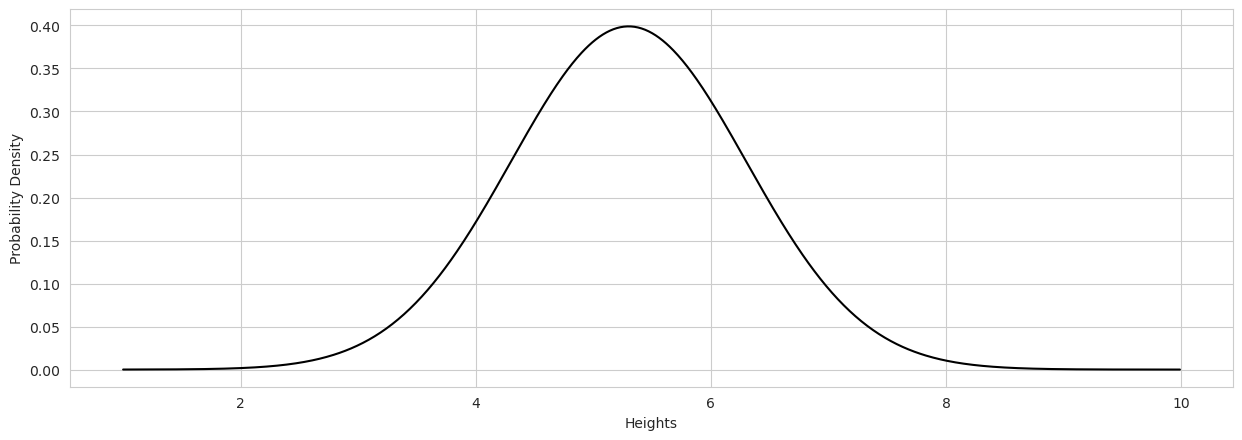

In [8]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
 
# Creating the distribution
data = np.arange(1,10,0.01)
pdf = norm.pdf(data , loc = 5.3 , scale = 1 )
 
#Visualizing the distribution
 
sb.set_style('whitegrid')
sb.lineplot(data, pdf , color = 'black')
plt.xlabel('Heights')
plt.ylabel('Probability Density')